## Demostrator 0
#### Purpose:
- In this example we download ERA5 data on-demand for training the IceNet2 model within the JASMIN environment

#### Comments:
- We recommend to install the libraries into a virtual or conda environment
- For instance, the notebook only works if you have in before
    - Installed the Copernicus Climate Data Store cdsapi package
    - Registered and setup your CDS API key as described on [their website here](https://cds.climate.copernicus.eu/api-how-to)

#### Credits:
- Some code snippets were adapted from the IceNet2 repository authored by Tom Ardersson (BAS)

#### Author: 
Alejandro Coca-Castro (The Alan Turing Institute)

## Set the environment

In [1]:
# Import the required packages
import virtualenv
import pip
import os

# Define and create the base directory install virtual environments
venvs_dir = os.path.join(os.path.expanduser("~"), "nb-venvs")

if not os.path.isdir(venvs_dir):
    os.makedirs(venvs_dir)
    
# Define the venv directory
venv_dir = os.path.join(venvs_dir, 'venv-cdi')

if not os.path.exists(venv_dir):
    # Create the virtual environment
    virtualenv.create_environment(venv_dir)
    
    # Install a set of required packages via `pip`
    requirements = ['cdsapi', 'intake']

    for pkg in requirements:
        pip.main(["install", "--prefix", venv_dir, pkg])
        
# Activate the venv
activate_file = os.path.join(venv_dir, "bin", "activate_this.py")
exec(open(activate_file).read(), dict(__file__=activate_file))

## Load libraries

In [2]:
import cdsapi
import xarray as xr
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt

## Request ERA5 data from CDI API

In [3]:
cds = cdsapi.Client()

In [4]:
# Settings - as defined by TAndersson
## Variables
variables = {
    'tas': {
        'cdi_name': '2m_temperature',
    },
    'tos': {
        'cdi_name': 'sea_surface_temperature',
    },
    'ta500': {
        'plevel': '500',
        'cdi_name': 'temperature',
    },
}

## Target months, days and times
months = [
    '01', '02', '03', '04', '05', '06',
    '07', '08', '09', '10', '11', '12'
]

days = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12',
    '13', '14', '15',
    '16', '17', '18',
    '19', '20', '21',
    '22', '23', '24',
    '25', '26', '27',
    '28', '29', '30',
    '31',
]

times = [
    '00:00', '01:00', '02:00',
    '03:00', '04:00', '05:00',
    '06:00', '07:00', '08:00',
    '09:00', '10:00', '11:00',
    '12:00', '13:00', '14:00',
    '15:00', '16:00', '17:00',
    '18:00', '19:00', '20:00',
    '21:00', '22:00', '23:00',
]

In [5]:
# Variables - as defined by TAndersson
var = 'tas'
hemisphere = 'nh'
year = 2020

# Output folder and files
var_folder = os.path.join(os.path.expanduser("~"),'data', hemisphere, var)
if not os.path.exists(var_folder):
    os.makedirs(var_folder)
    
download_path = os.path.join(var_folder, '{}_latlon_hourly_{}_{}.nc'.format(var, year, year))
daily_fpath = os.path.join(var_folder, '{}_latlon_{}_{}.nc'.format(var, year, year))

In [6]:
# Settings - as defined by TAndersson
## Hemisphere
if hemisphere == 'nh':
    area = [90, -180, 0, 180]
elif hemisphere == 'sh':
    area = [-90, -180, 0, 180]
elif hemisphere == 'nh_sh':
    area = [-90, -180, 90, 180]

## Target var dictionary
var_dict = variables[var]

## Retrieve dictionary
retrieve_dict = {
    'product_type': 'reanalysis',
    'variable': var_dict['cdi_name'],
    'year': year,
    'month': months,
    'day': days,
    'time': times,
    'format': 'netcdf',
    'area': area
}

if 'plevel' not in var_dict.keys():
    dataset_str = 'reanalysis-era5-single-levels'

elif 'plevel' in var_dict.keys():
    dataset_str = 'reanalysis-era5-pressure-levels'
    retrieve_dict['pressure_level'] = var_dict['plevel']

In [7]:
%%time
# check if file exist, otherwise retrieve the target variable from CDI
if not Path(download_path).is_file():
    cds.retrieve(dataset_str, retrieve_dict, download_path)

CPU times: user 0 ns, sys: 215 µs, total: 215 µs
Wall time: 342 µs


## Load and resample from hourly to daily

In [8]:
%%time
# Import using open_dataarray
da = xr.open_dataarray(download_path)

CPU times: user 22.2 ms, sys: 4.06 ms, total: 26.3 ms
Wall time: 28.6 ms


In [9]:
%%time
print('\n\nComputing daily averages... ', end='', flush=True)
da_daily = da.resample(time='1D').reduce(np.mean)

if var == 'zg500' or var == 'zg250':
    da_daily = da_daily / 9.80665

if var == 'tos':
    # Replace every value outside of SST < 1000 with zeros (the ERA5 masked values)
    da_daily = da_daily.where(da_daily < 1000., 0)



Computing daily averages... CPU times: user 28.2 s, sys: 17.5 s, total: 45.7 s
Wall time: 45.8 s


In [10]:
if not Path(daily_fpath).is_file():
    print(np.unique(da_daily.data)[[0, -1]])  # TEMP
    print('saving new daily year file... ', end='', flush=True)
    da_daily.to_netcdf(daily_fpath)

## Visualization

CPU times: user 129 ms, sys: 8.26 ms, total: 137 ms
Wall time: 136 ms


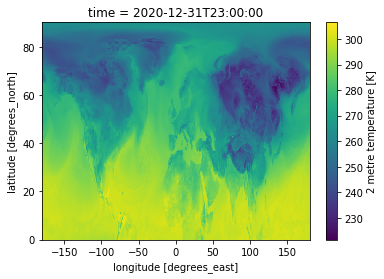

In [11]:
%%time
# plot the last timestep
da.isel(time=-1).plot()

CPU times: user 56.4 ms, sys: 47.6 ms, total: 104 ms
Wall time: 79.8 ms


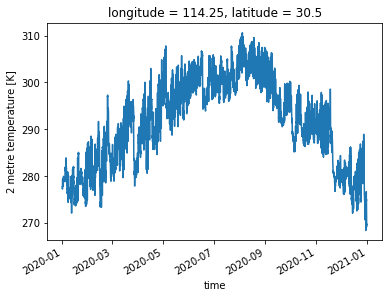

In [12]:
%%time
# plot a timeseries at one location
da.sel(longitude=114.3055, latitude=30.5928, method='nearest').plot()